In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import awkward as ak
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/event_based/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_pt = f["trk_pT"].array()
    trk_eta = f["trk_eta"].array()
    trk_phi = f["trk_phi"].array()
    trk_q = f["trk_q"].array()
    trk_d0 = f["trk_d0"].array()
    trk_z0 = f["trk_z0"].array()
    trk_label = f["trk_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()

### Associate Tracks to Jets

In [3]:
%%time
num_events = len(jet_pt)
trk_feats = []
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    idx_list = list(jet_trk_IDX[event])
    idx_list.append(len(trk_pt[event]))
    
    jet_trk_feats = []
    for i in range(len(idx_list)-1):
        start_idx = idx_list[i]
        end_idx = idx_list[i+1]-1 
        trk_pt_tmp = np.array(trk_pt[event][start_idx:end_idx])
        trk_eta_tmp = np.array(trk_eta[event][start_idx:end_idx])
        trk_phi_tmp = np.array(trk_phi[event][start_idx:end_idx])
        trk_q_tmp = np.array(trk_q[event][start_idx:end_idx])
        trk_d0_tmp = np.array(trk_d0[event][start_idx:end_idx])
        trk_z0_tmp = np.array(trk_z0[event][start_idx:end_idx])
        trk_label_tmp = np.array(trk_label[event][start_idx:end_idx])

        feats = [trk_pt_tmp, trk_eta_tmp, trk_phi_tmp, trk_q_tmp,
                trk_d0_tmp, trk_z0_tmp, trk_label_tmp]
        feats = np.stack(feats, axis=-1)
        jet_trk_feats.append(feats)
    
    trk_feats.append(jet_trk_feats)
    
trk_feats = ak.Array(trk_feats)

print("Processing: ", num_events, " / ", num_events)
print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Processing:  1000  /  1000
Num Events:  1000
Num Jets in first event:  22
Num Tracks in first event first jet:  82
Num Tracks features:  7
CPU times: user 22.9 s, sys: 158 ms, total: 23 s
Wall time: 23 s


In [4]:
%%time
num_events = len(jet_pt)
jet_feats = []
for event in range(num_events):
    jet_pt_tmp = np.array(jet_pt[event])
    jet_eta_tmp = np.array(jet_eta[event])
    jet_phi_tmp = np.array(jet_phi[event])

    feats = [jet_pt_tmp, jet_eta_tmp, jet_phi_tmp]
    feats = np.stack(feats, axis=-1)
    
    jet_feats.append(feats)
    
jet_feats = ak.Array(jet_feats)

print(jet_feats)
print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

[[[146, -0.157, 2.52], [113, ..., 0.0962], ..., [26.7, -2.63, 4.82]], ...]
Num Events:  1000
Num Jets in first event:  22
Num Jet Features:  3
CPU times: user 525 ms, sys: 6.37 ms, total: 532 ms
Wall time: 517 ms


### Define Jet Class

In [5]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def set_binary_label(self):
        if self.label == 0:
            self.binary_label = np.float32(0)
        else:
            self.binary_label = np.float32(1)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label).reshape([1])
        self.binary_label = torch.tensor(self.binary_label).reshape([1])
        
    def norm_data(self, jet_means, trk_means, jet_stds, trk_stds):
        self.jet_features = torch.div(torch.sub(self.jet_features,jet_means),jet_stds)
        self.trk_features = torch.div(torch.sub(self.trk_features,trk_means),trk_stds)

### Apply Cuts, Read data into Jet class, and store on Event Basis

CPU times: user 1min 14s, sys: 150 ms, total: 1min 14s
Wall time: 1min 14s


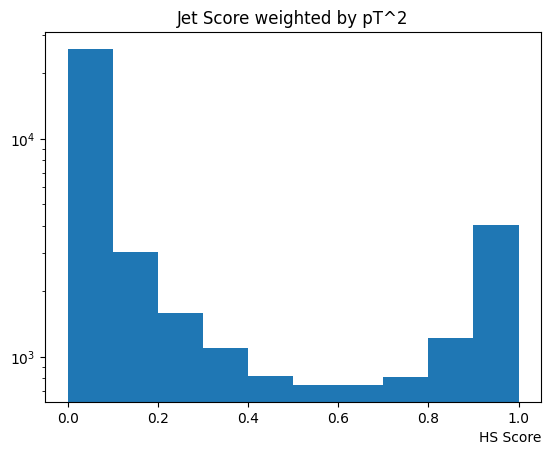

In [6]:
%%time     
Event_Jet_List = []
num_events = len(jet_pt)
for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    Jet_List = []
    num_jets = len(jet_feats[event])
    jet_eta_cut = jet_feats[event]
    for jet in range(num_jets):
        if abs(jet_feats[event][jet][1])>4:
            continue
        
        trk_q_cut = trk_feats[event][jet][:,3]!=0
        trk_eta_cut = abs(trk_feats[event][jet][:,1])<4
        trk_pt_cut = trk_feats[event][jet][:,0]>0.4
        
        mask = trk_q_cut & trk_eta_cut & trk_pt_cut
        #not_mask = ~mask
        
        pass_trks = trk_feats[event][jet][mask]
        #fail_trks = trk_feats[event][jet][not_mask]
        
        jet_f = np.array(jet_feats[event][jet], dtype=np.float32)
        trk_f = np.array(pass_trks[:,0:3], dtype=np.float32)
        trk_l = np.array(pass_trks[:,-1], dtype=np.float32)
        
        Jet_List.append(Jet(jet_f,trk_f,trk_l))
        
    Event_Jet_List.append(Jet_List)

label = []
for event in range(num_events):
    for jet in Event_Jet_List[event]:
        jet.set_label(jet.get_label())
        jet.set_binary_label()
        jet.convert_to_tensor()
        
        # List for plotting labels
        label.append(float(jet.label))
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Generate Track Tensor

In [7]:
%%time
# Apply Cuts on Tracks
pt_cut = (trk_pt > 0.4)
eta_cut = ((trk_eta < 4) & (trk_eta > -4))
q_cut = (trk_q != 0)
mask = q_cut & eta_cut & pt_cut
pt_trk = trk_pt[mask]
eta_trk = trk_eta[mask]
phi_trk = trk_phi[mask]
    
# Loop over Events and store tracks as torch tensor
Event_Track_List = []
for i in range(num_events):
    trk_pt_tmp = torch.reshape(torch.Tensor(pt_trk[i]),(-1,1))
    trk_eta_tmp = torch.reshape(torch.Tensor(eta_trk[i]),(-1,1))
    trk_phi_tmp = torch.reshape(torch.Tensor(phi_trk[i]),(-1,1))
    
    trk_feats = torch.cat([trk_pt_tmp, trk_eta_tmp, trk_phi_tmp],1)
    Event_Track_List.append(trk_feats)

CPU times: user 2.4 s, sys: 2.98 ms, total: 2.4 s
Wall time: 2.4 s


### Generate Jet Tensor

In [8]:
%%time
Jet_Data_List = []
Jet_Label_List = []
for i in range(num_events):
    jet_feats = []
    jet_labels = []
    for j in range(len(Event_Jet_List[i])):
        jet_feats_tmp = torch.reshape(Event_Jet_List[i][j].jet_features,(1,3))
        jet_feats.append(jet_feats_tmp)
        
        jet_labels.append(Event_Jet_List[i][j].label)
        
        
    jet_feats = torch.cat(jet_feats, 0)
    Jet_Data_List.append(jet_feats)
    
    jet_labels = torch.reshape(torch.cat(jet_labels, 0),(-1,1))
    Jet_Label_List.append(jet_labels)
    
print(Jet_Data_List[0].shape)
print(Jet_Label_List[0].shape)

torch.Size([19, 3])
torch.Size([19, 1])
CPU times: user 48.5 ms, sys: 1.01 ms, total: 49.5 ms
Wall time: 49.3 ms


### Pad Number of Tracks per Jet

In [9]:
##################
### DEBUG CODE ###
##################
print("Before:")
len_list = []
for i in range(len(Event_Jet_List[0])):
    len_list.append(len(Event_Jet_List[0][i].trk_features))
print("Max: ", max(len_list))
print("Min: ", min(len_list))

num_events = len(Event_Jet_List)
for event in range(num_events):
    max_list = []
    for jet in Event_Jet_List[event]:
        max_list.append(len(jet.trk_features))
    max_num_trks = max(max_list)
    
    for jet in Event_Jet_List[event]:
        pad = (0,0,0,max_num_trks-len(jet.trk_features))
        out_trk = F.pad(jet.trk_features,pad)
        jet.trk_features = out_trk
        
##################
### DEBUG CODE ###
##################
print("After:")
len_list = []
for i in range(len(Event_Jet_List[0])):
    len_list.append(len(Event_Jet_List[0][i].trk_features))
print("Max: ", max(len_list))
print("Min: ", min(len_list))

Before:
Max:  24
Min:  10
After:
Max:  24
Min:  24


### Generate Track Tensor

In [10]:
Jet_Trk_Data_List = []
Jet_Trk_Label_List = []
for i in range(num_events):
    trk_feats = []
    trk_labels = []
    num_jets = len(Event_Jet_List[i])
    for j in range(num_jets):
        trk_feats_tmp = torch.unsqueeze(Event_Jet_List[i][j].trk_features,0)
        trk_feats.append(trk_feats_tmp)
            
    trk_feats = torch.cat(trk_feats, 0)
    Jet_Trk_Data_List.append(trk_feats)
        
print(Jet_Trk_Data_List[0].shape)

torch.Size([19, 24, 3])


### Shuffle Events and Test Train Split

In [11]:
Event_List = list(zip(Jet_Data_List,Jet_Trk_Data_List,Event_Track_List,Jet_Label_List))
random.shuffle(Event_List)

Events_training = Event_List[0:int(0.6*num_events)]
Events_validation = Event_List[int(0.6*num_events):int(0.7*num_events)]
Events_testing = Event_List[int(0.7*num_events):]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

Processing:  1000  /  1000
Training Events:  600
Validation Events:  100
Testing Events:  300


In [12]:
"""
class TensorDataset(Dataset):
    def __init__(self, Event_List):
        Jet_List, Trk_List, Jet_Labels = zip(*Event_List)
        self.jet_feats = Jet_List
        self.trk_feats = Trk_List
        self.jet_labels = Jet_Labels

    def __len__(self):
        return len(self.jet_labels)

    def __getitem__(self, idx):
        return self.jet_feats[idx], self.trk_feats[idx], self.jet_labels[idx]
    
    def custom_collate_fn(batch):
        data1_list, data2_list, label_list = zip(*batch)
        data1_batch = torch.stack(data1_list)
        label_batch = torch.stack(label_list)
        return data1_batch, data2_batch, label_batch
        
    
dataset = TensorDataset(Events_training)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
"""

'\nclass TensorDataset(Dataset):\n    def __init__(self, Event_List):\n        Jet_List, Trk_List, Jet_Labels = zip(*Event_List)\n        self.jet_feats = Jet_List\n        self.trk_feats = Trk_List\n        self.jet_labels = Jet_Labels\n\n    def __len__(self):\n        return len(self.jet_labels)\n\n    def __getitem__(self, idx):\n        return self.jet_feats[idx], self.trk_feats[idx], self.jet_labels[idx]\n    \n    def custom_collate_fn(batch):\n        data1_list, data2_list, label_list = zip(*batch)\n        data1_batch = torch.stack(data1_list)\n        label_batch = torch.stack(label_list)\n        return data1_batch, data2_batch, label_batch\n        \n    \ndataset = TensorDataset(Events_training)\ndataloader = DataLoader(dataset, batch_size=1, shuffle=True)\n'

### Define Model

In [65]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 1
        self.num_jet_feats = 3
        self.num_trk_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        self.multihead_attn_jet_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)

            
        self.multihead_attn_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.cross_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.multihead_attn_jet = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.post_process1 = nn.Linear(self.embed_dim, self.embed_dim*8)
        self.post_process2 = nn.Linear(self.embed_dim*8, self.embed_dim)
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        query = jet_trk_init
        key = jet_trk_init
        value = jet_trk_init
        jet_trk_embedding, trk_weights = self.multihead_attn_jet_trk(query, key, value)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))

        # Cross Attention
        query = jet_embedding
        key = trk_init
        value = trk_init
        jet_attention, jet_weights = self.multihead_attn_trk(query, key, value)
        jet_attention = self.cross_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.cross_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.cross_post_process(jet_embedding))
        
        # Update embeddings of jets in the contex of entire event
        query = jet_embedding
        key = jet_embedding
        value = jet_embedding
        jet_attention, jet_weights = self.multihead_attn_jet(query, key, value)
        jet_attention = self.jet_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.jet_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.jet_post_process(jet_embedding))
        
        # Get output
        jet_embedding = F.relu(self.post_process1(jet_embedding))
        jet_embedding = F.relu(self.post_process2(jet_embedding))
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights

In [66]:
model = Model()
print(model)
output, jet_weights, trk_weights = model(Events_training[0][0],Events_training[0][1],Events_training[0][2])
print()
print(output.shape)
print(jet_weights.shape)
print(trk_weights.shape)

Model(
  (jet_initializer): Linear(in_features=3, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=3, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=3, out_features=256, bias=True)
  (multihead_attn_jet_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_postprocess): Linear(in_features=512, out_features=256, bias=True)
  (multihead_attn_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (cross_post_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_combined_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_post_process): Linear(in_features=256, out_features=256, bias=True)
  (multihead_attn_jet): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_post_layer_norm): L

### Define Training Loop

In [67]:
def train(model, data, epochs=40):
    train_data, validation_data = data
    
    combined_history = []
    
    num_train = len(Events_training)
    num_val = len(Events_validation)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            jets_train, jet_trks_train, trks_train, train_labels = Events_training[i]
    
            optimizer.zero_grad()
            
            output, jet_weights, trk_weights = model(jets_train.to(device), jet_trks_train.to(device), trks_train.to(device))
            
            loss=loss_fn1(output, train_labels.to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            jets_val, jet_trks_val, trks_val, val_labels = Events_validation[i]
            output, jet_weights, trk_weights = model(jets_val.to(device), jet_trks_val.to(device), trks_val.to(device))
            loss=loss_fn1(output, val_labels.to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val

        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history)

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.150167 	Val Loss: 0.123677
Epoch: 1 	Train Loss: 0.112869 	Val Loss: 0.095759
Epoch: 2 	Train Loss: 0.079303 	Val Loss: 0.056495
Epoch: 3 	Train Loss: 0.053504 	Val Loss: 0.04232
Epoch: 4 	Train Loss: 0.047407 	Val Loss: 0.038906
Epoch: 5 	Train Loss: 0.045458 	Val Loss: 0.037509
Epoch: 6 	Train Loss: 0.044423 	Val Loss: 0.036772
Epoch: 7 	Train Loss: 0.04376 	Val Loss: 0.036327
Epoch: 8 	Train Loss: 0.043281 	Val Loss: 0.036019
Epoch: 9 	Train Loss: 0.042888 	Val Loss: 0.035771
Epoch: 10 	Train Loss: 0.042575 	Val Loss: 0.035589
Epoch: 11 	Train Loss: 0.042309 	Val Loss: 0.03546
Epoch: 12 	Train Loss: 0.042101 	Val Loss: 0.035352
Epoch: 13 	Train Loss: 0.041903 	Val Loss: 0.035261
Epoch: 14 	Train Loss: 0.04172 	Val Loss: 0.035174
Epoch: 15 	Train Loss: 0.041589 	Val Loss: 0.035103
Epoch: 16 	Train Loss: 0.041453 	Val Loss: 0.035047
Epoch: 17 	Train Loss: 0.041295 	Val Loss: 0.03498
Epoch: 18 	Train Loss: 0.041178 	Val Loss: 0.03492

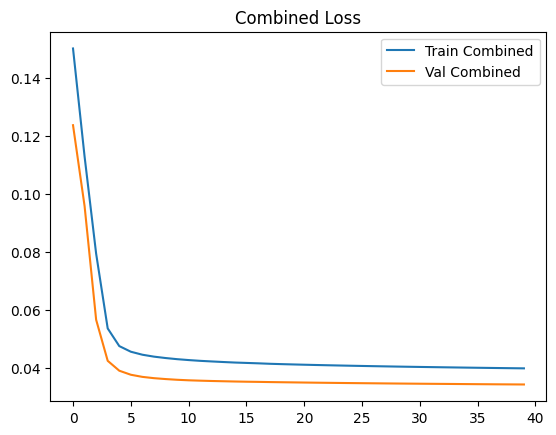

In [68]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

loss_fn1 = nn.MSELoss()

combined_history = train(model, [Events_training, Events_validation])

plt.plot(combined_history[:,0], label="Train Combined")
plt.plot(combined_history[:,1], label="Val Combined")
plt.title('Combined Loss')
plt.legend()
plt.show()

### Evaluate Model

Train Loss:	 0.039714966885124645
Val Loss:	 0.03414759854786098
Test Loss:	 0.041941625967932245

Test MAE:	 0.129191477020606
Test RMSE:	 0.19058710947744198


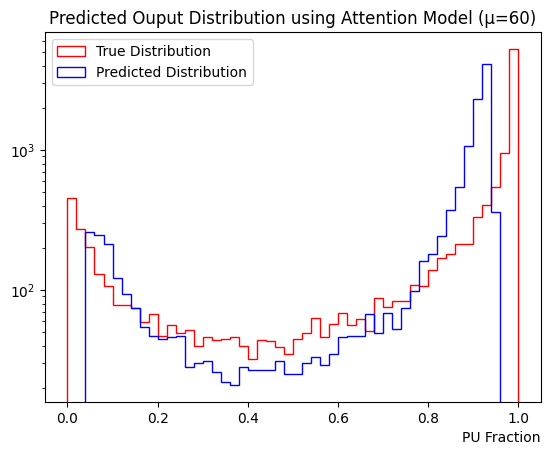

In [69]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(Events_testing)
for i in range(num_test):
    jets_test, jet_trks_test, trks_test, test_labels = Events_testing[i]
    output, jet_weights, trk_weights = model(jets_test.to(device), jet_trks_test.to(device), trks_test.to(device))
    
    loss=loss_fn1(output, test_labels.to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(1-float(output[j][0].detach().cpu().numpy()))
        true_labels.append(1-float(test_labels[j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

### Visualize Attention Scores

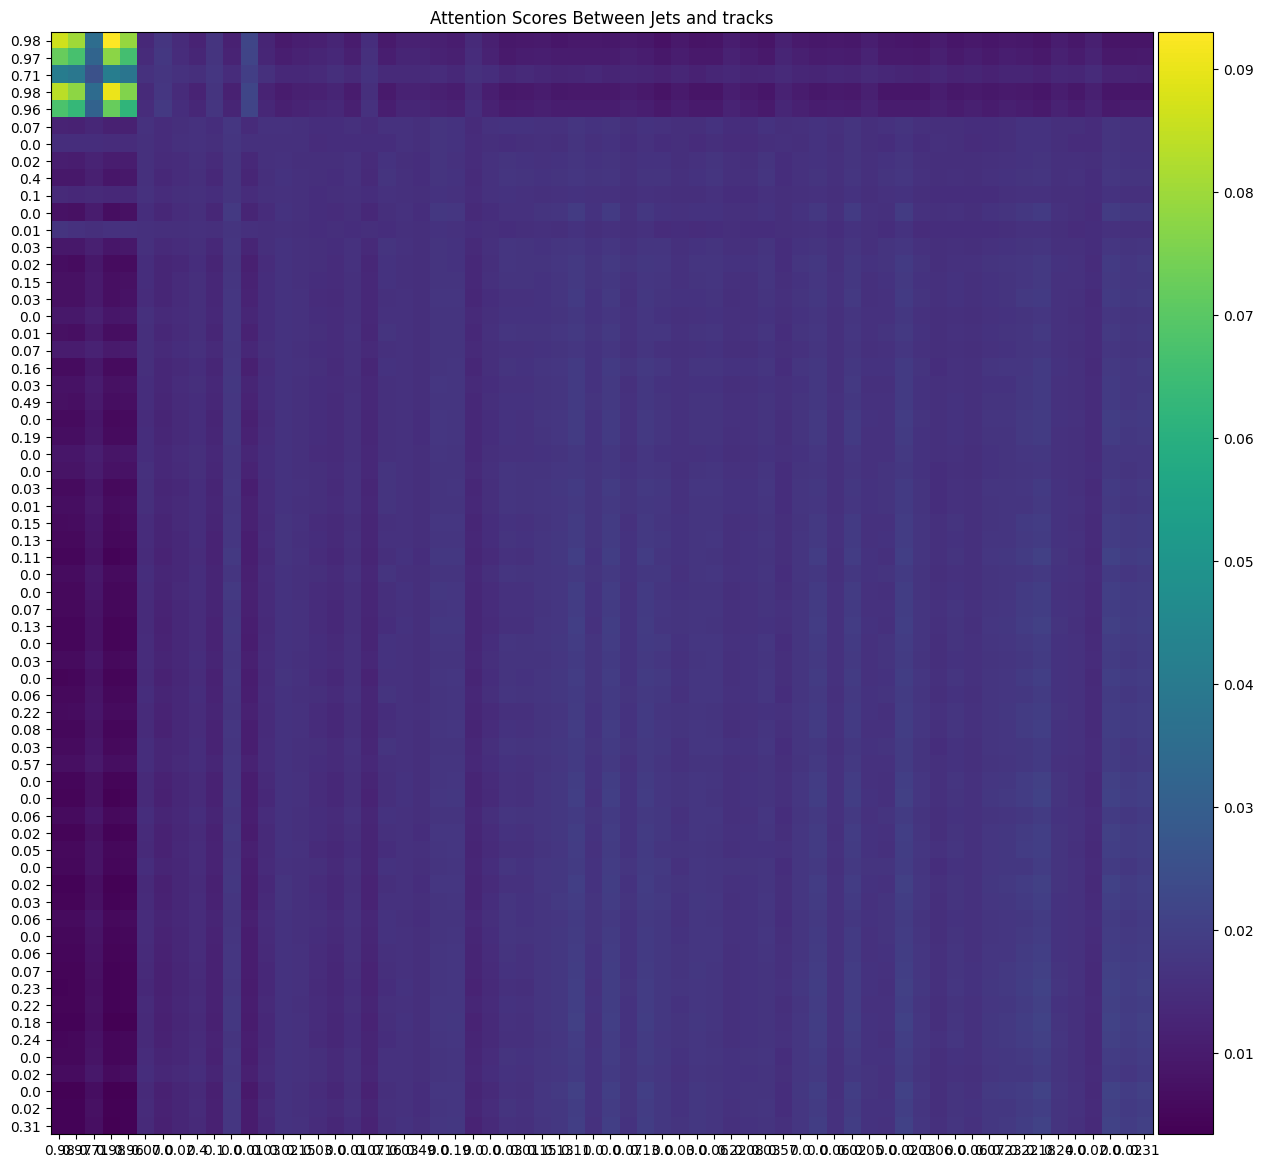

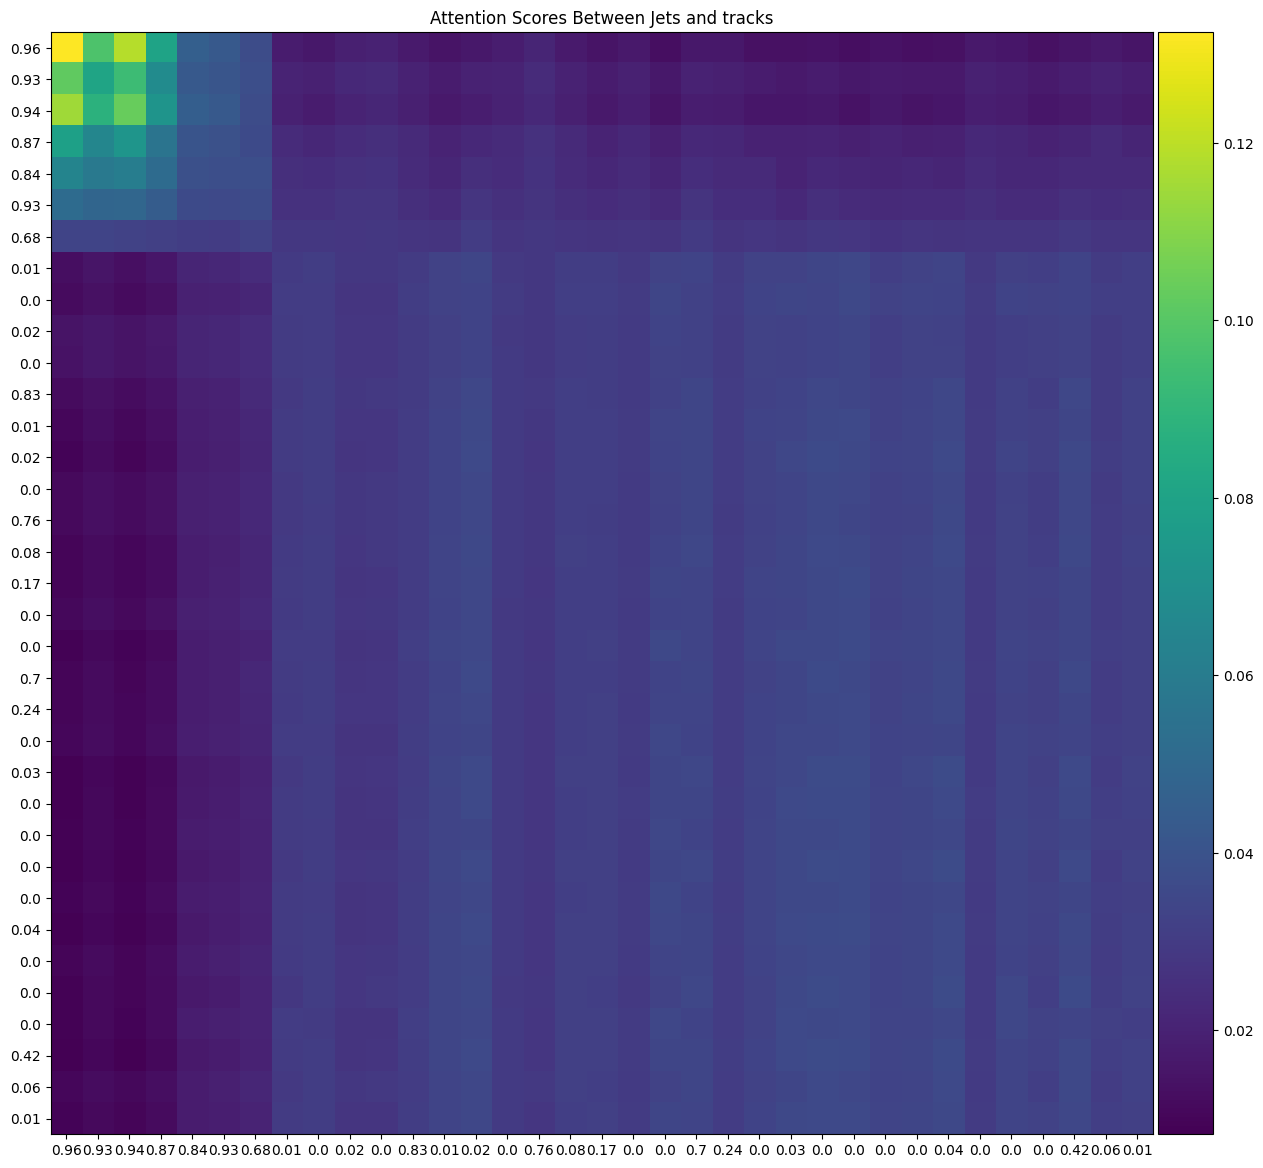

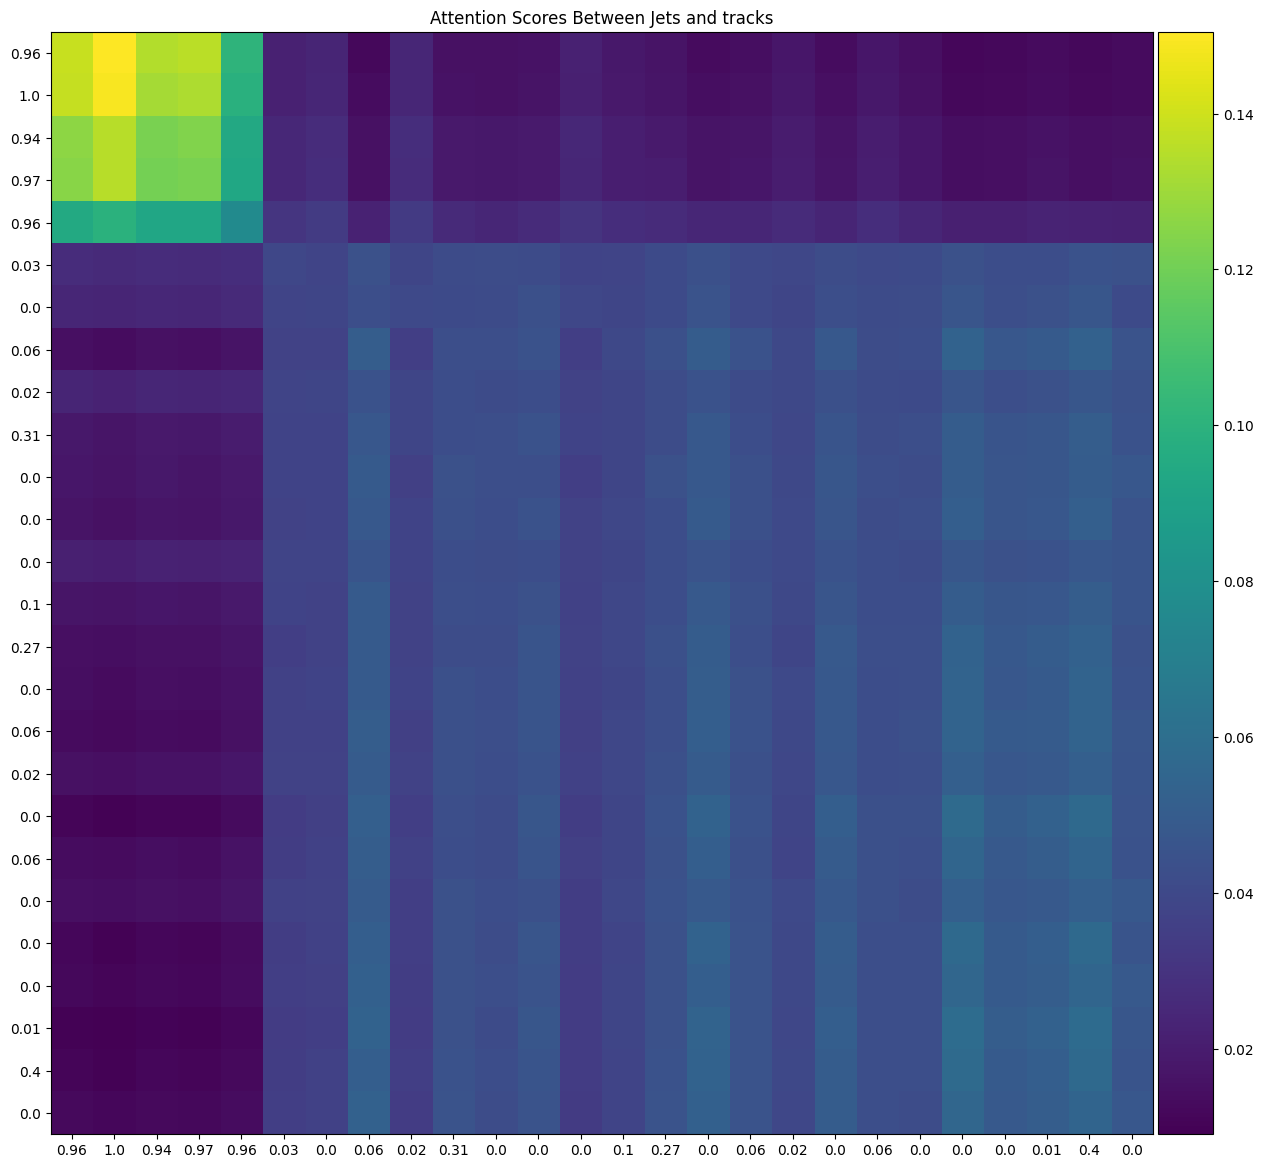

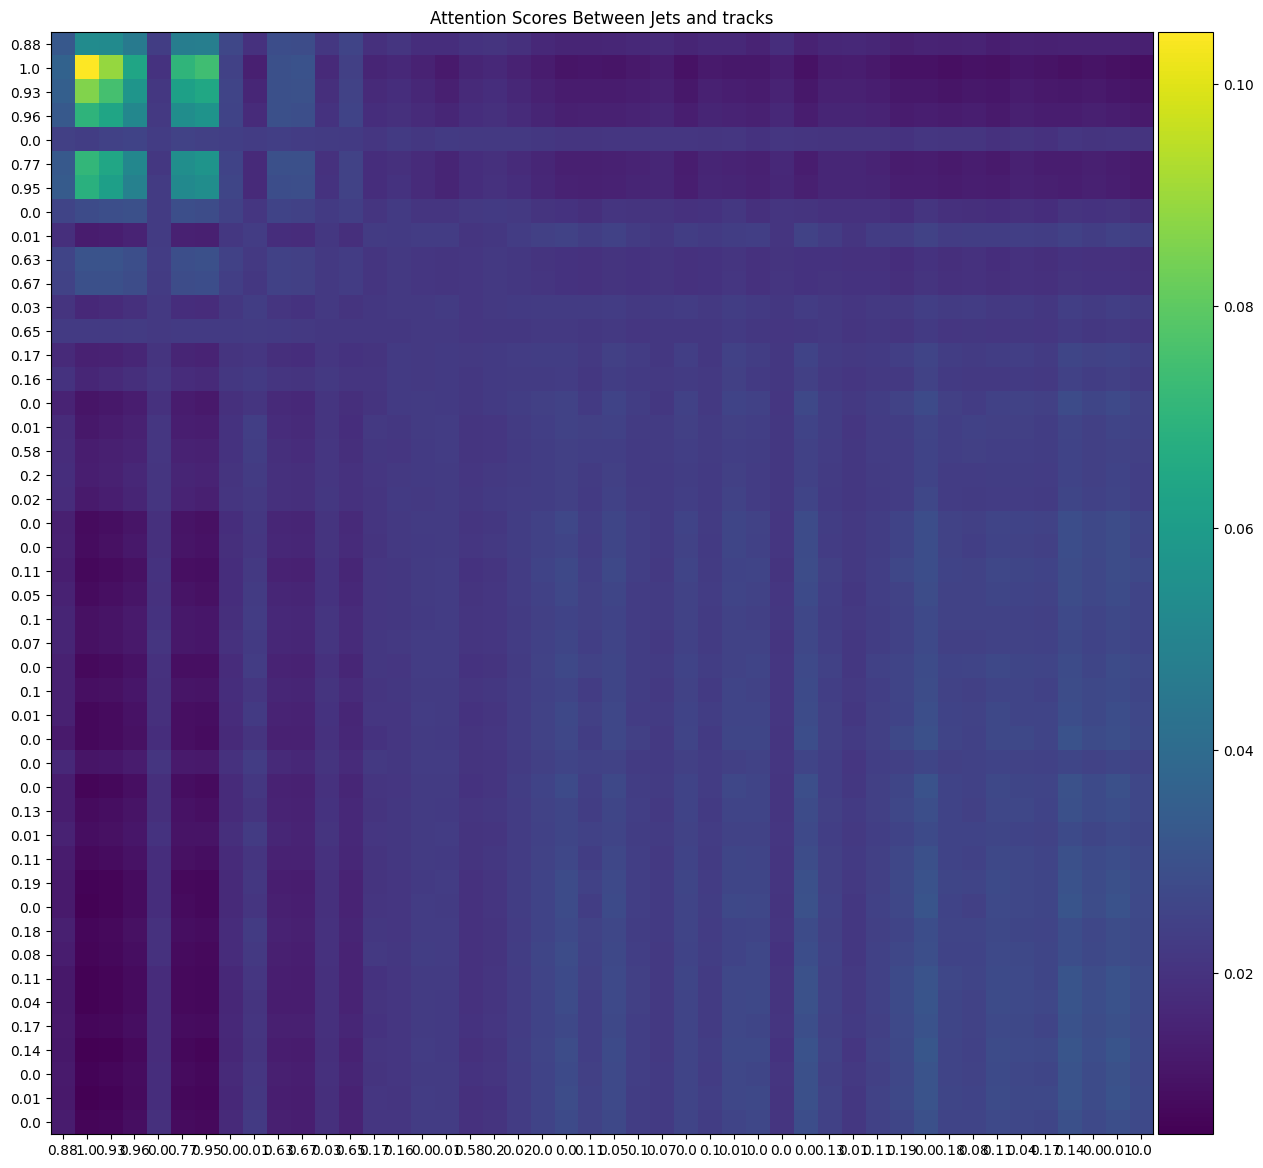

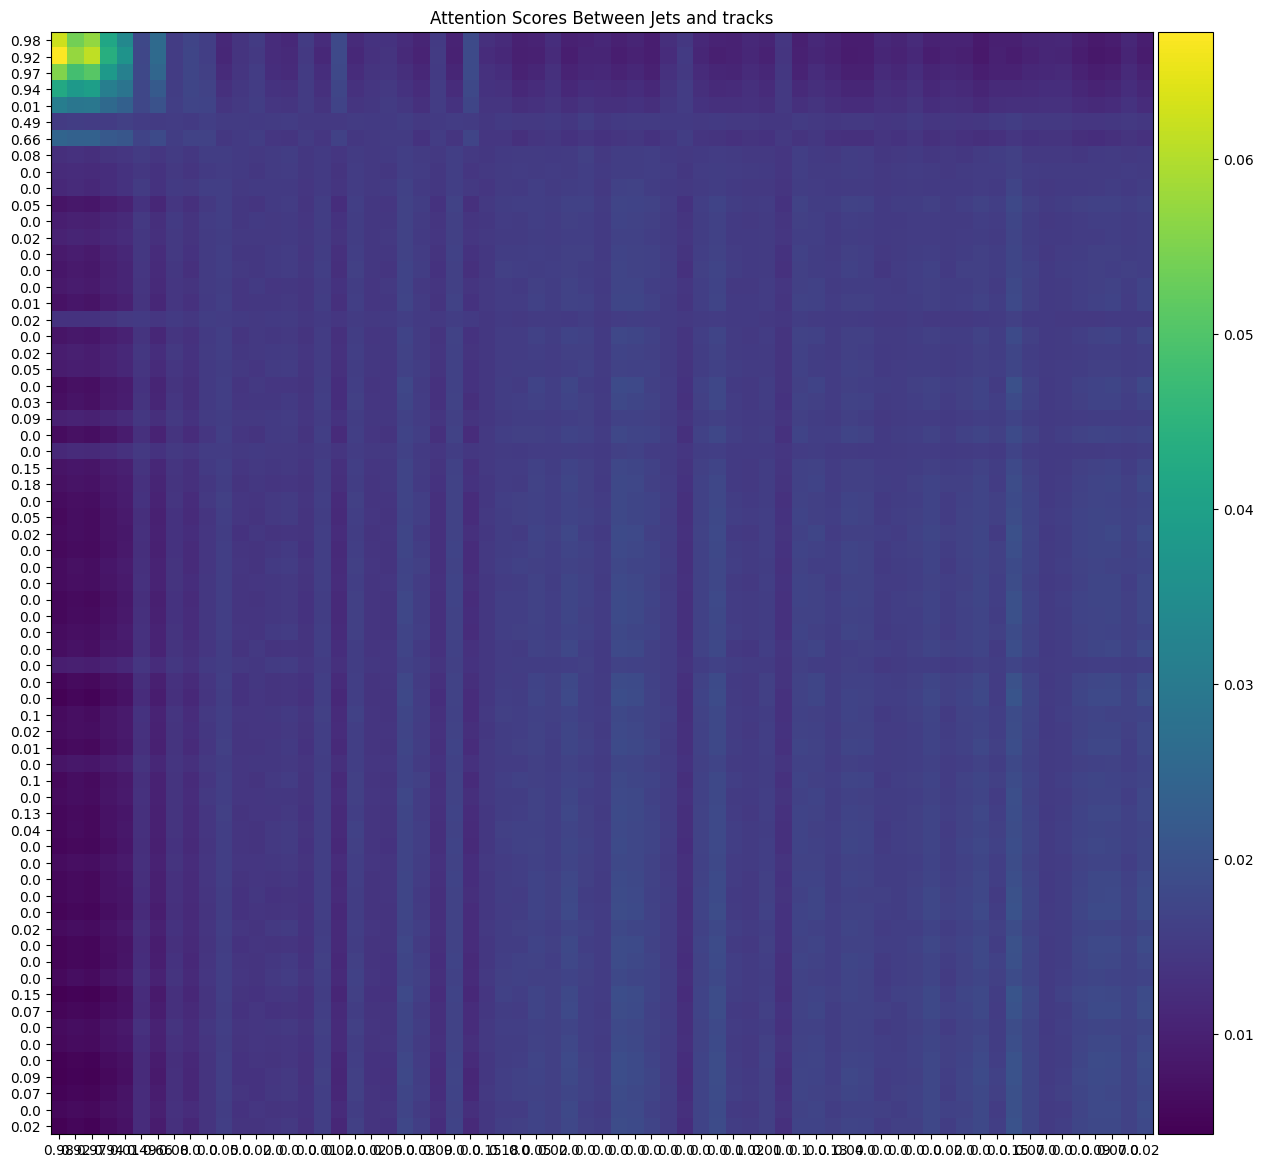

In [70]:
plot_events=5
for i in range(plot_events):
    
    jets_test, jet_trks_test, trks_test, test_labels = Events_testing[i]
    
    # Get Model Predictions
    model.eval()
    output, jet_weights, trk_weights = model(jets_test.to(device), jet_trks_test.to(device), trks_test.to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in test_labels]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets and tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')